# Lung Nodule Classification using Deep Learning
Lung nodules are any sort of abnormal growths that measure less than 3 centimeters (above 3 cm, they are referred to as a lung mass). Many modules can be recognized by radiologists with a high degree of accuracy by using a regular chest x-ray. We are going to use machine learning to attempt to recognize whether or not a lung leison is present in a given x-ray image.

# Set up
First, we'll import the libraries that we'll need, and set up the notebook appropriately.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, re
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

import pylab
import boto
import gcs_oauth2_boto_plugin

from matplotlib.pyplot import imshow
from PIL import Image
from io import BytesIO
from IPython import display

# Our utility functions
import util

def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)



# Setup access to data
We need to set up the access to google's Storage api to get at the data

In [2]:
PROJECT_ID = "bmi260-1322"
header_values = {"x-goog-project-id": PROJECT_ID}

# URI scheme for Cloud Storage.
GOOGLE_STORAGE = 'gs'

# URI scheme for accessing local files.
LOCAL_FILE = 'file'

# Create bucket's URI
uri = boto.storage_uri('bmi260-project-data', GOOGLE_STORAGE)
bucket = uri.get_bucket(headers=header_values)

# Explore the data
Next, we'll load up the truth data and visualize one lung nodule

In [3]:
# Load the Truth
truth = util.load_truth_data(bucket)
truth['label'] = truth['diagnosis'] != 'non-nodule'
truth

,age,diagnosis,location,pathology,sex,size,subtlety,x,y,label
filename,,,,,,,,,,
JPCLN001.IMG,53,lung cancer,l.upper,malignant,male,15.0,5.0,1634.0,692.0,True
JPCLN002.IMG,78,pulmonary hematoma,l.upper,benign,female,30.0,5.0,1614.0,1090.0,True
JPCLN003.IMG,63,lung cancer,l.upper,malignant,female,30.0,5.0,1303.0,447.0,True
JPCLN004.IMG,68,inflammatory mass,r.upper,benign,female,14.0,5.0,606.0,836.0,True
JPCLN005.IMG,73,lung cancer,l.upper,malignant,female,35.0,5.0,1438.0,692.0,True
JPCLN006.IMG,64,tuberculoma,r.upper,benign,female,14.0,5.0,660.0,524.0,True
JPCLN007.IMG,69,lung cancer,r.upper,malignant,male,18.0,5.0,459.0,852.0,True
JPCLN008.IMG,44,granuloma,r.lower,benign,female,10.0,5.0,508.0,938.0,True
JPCLN009.IMG,61,lung cancer,l.lower,malignant,female,28.0,5.0,1593.0,930.0,True


In [4]:
def show_image(truth, filename):
    sample_image = filename
    nodule1_image = util.load_image_from_bucket(bucket, "All247images/{}".format(sample_image))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    x = truth.ix[sample_image]['x']
    y = truth.ix[sample_image]['y']

    imshow(nodule1_image, cmap='Greys_r')
    ax.annotate('nodule', xy=(x, y), xytext=(x*1.05, y*1.05), color='white',
                arrowprops=dict(facecolor='white', shrink=0.05),
                )

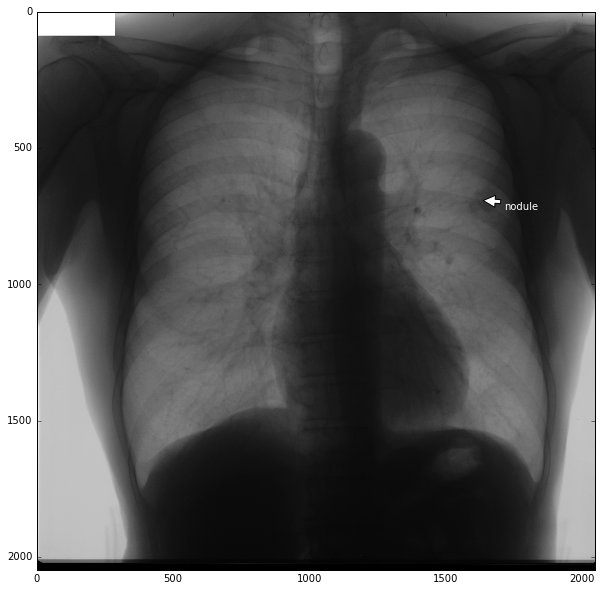

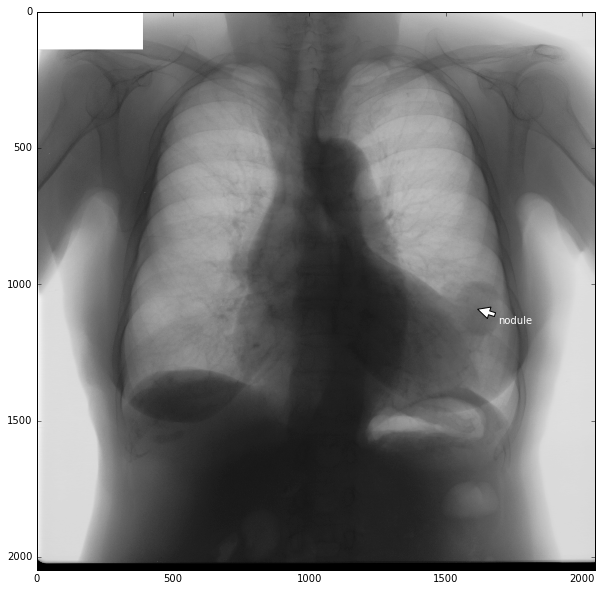

In [5]:
# Render some examples
show_image(truth,'JPCLN001.IMG')
show_image(truth,'JPCLN002.IMG')


# Load data
Load all of the data into one big array for training purposes

In [9]:

def load_from_cloud(bucket):
    # Get all the images
    image_keys = list(bucket.list('All247images'))
    filenames = map(lambda x: os.path.split(x.name)[1], image_keys)

    # Initialize dataset map
    dataset_dict = {'filename':[], 'data': []}
    # Fill up dataset
    for i, key in enumerate(image_keys):
        filename = os.path.split(key.name)[1]
        image = util.load_image_from_bucket(bucket, key.name)
        dataset_dict['filename'].append(filename)
        dataset_dict['data'].append(image)
        
    dataset_dict['data'] = np.array(dataset_dict['data'])
    dataset_dict['filename'] = np.array(dataset_dict['filename'])
    return dataset_dict

def load_from_local():
    # Get all the images
    base_dir = '/home/matt/All247images'
    filenames = os.listdir(base_dir)

    # Initialize dataset map
    dataset_dict = {'filename':[], 'data': []}
    # Fill up dataset
    for i, filename in enumerate(filenames):
        image = util.load_image_file(os.path.join(base_dir, filename))
        dataset_dict['filename'].append(filename)
        dataset_dict['data'].append(image)
    
    dataset_dict['data'] = np.array(dataset_dict['data'])
    dataset_dict['filename'] = np.array(dataset_dict['filename'])
    return dataset_dict

dataset_dict = load_from_local()

In [7]:
# df = pd.DataFrame(dataset_dict, index=dataset_dict['filename'])
# dataset = truth.join(df)
# dataset['label'] = (dataset['diagnosis'] != 'non-nodule').astype(np.float32)
# dataset.ix['JPCLN001.IMG']


# Split data into training, validation, test datasets
Now that we have the data, we need to split it into a training, validation, and test datasets.

In [38]:
from sklearn.cross_validation import train_test_split
data = np.array(dataset_dict['data']).astype(np.float32)
labels = truth.ix[dataset_dict['filename']]['label'].as_matrix().astype(np.float32)
print data.shape, labels.shape

train_dataset, valid_test_dataset, train_labels, valid_test_labels = train_test_split(
    data, labels, train_size=0.9)

print train_dataset.shape, train_labels.shape, valid_test_dataset.shape, valid_test_labels.shape

valid_dataset, test_dataset, valid_labels, test_labels = train_test_split(
    valid_test_dataset, valid_test_labels, train_size=0.5)
print "(training, validation, test) =", (train_dataset.shape, valid_dataset.shape, test_dataset.shape)
print "(training labels, validation labels, test labels) =", (train_labels.shape, valid_labels.shape, test_labels.shape)


# Make all the data tensorflow friendly
batch_size = 16
num_channels = 1 # Greyscale
num_labels = 2
image_size = util.WIDTH
patch_size = 5
num_hidden = 64
depth = 16

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, util.HEIGHT, util.WIDTH, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

(247, 2048, 2048) (247,)
(222, 2048, 2048) (222,) (25, 2048, 2048) (25,)
(training, validation, test) = ((222, 2048, 2048), (12, 2048, 2048), (13, 2048, 2048))
(training labels, validation labels, test labels) = ((222,), (12,), (13,))
Training set (222, 2048, 2048, 1) (222, 2)
Validation set (12, 2048, 2048, 1) (12, 2)
Test set (13, 2048, 2048, 1) (13, 2)


# Set up the neural net
Now it's time to set up our neural net in tensor flow. To begin with, we will make a few utility functions to make our layers easier to construct.

In [12]:
# We'll use the inception architecture for our layers
import inception.slim as slim
import inception.slim.inception_model as inception_model

In [39]:
#
# Set up a simple 4-dept network
# 



# def model(inputs, scope):
#     with slim.scopes.arg_scope([slim.ops.conv2d, slim.ops.fc], stddev=0.01, weight_decay=0.0005):
#         net = slim.ops.repeat_op(2, inputs, slim.ops.conv2d, 12, [9, 9], scope=scope + '/conv1')
#         net = slim.ops.max_pool(net, [4, 4], scope=scope + '/pool1')
#         net = slim.ops.repeat_op(2, net, slim.ops.conv2d, 128, [9, 9], scope=scope + '/conv2')
#         net = slim.ops.max_pool(net, [4, 4], scope=scope + '/pool2')
#         net = slim.ops.flatten(net, scope=scope + '/flatten5')
#         net = slim.ops.fc(net, 2, scope=scope + '/fc6')
#         net = slim.ops.dropout(net, 0.5, scope=scope + '/dropout6')
#         net = slim.ops.fc(net, 4096, scope=scope + '/fc7')
#         net = slim.ops.dropout(net, 0.5, scope=scope + 'dropout7')
#         net = slim.ops.fc(net, 2, activation=None, scope=scope + 'fc8')
#         return net


graph = tf.Graph()

with graph.as_default():
    
    # Input Data
    tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    def model(inputs, scope):
        # Model
        conv = tf.nn.conv2d(inputs, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    
    # Build the graph
    logits = model(tf_train_dataset, 'train')
    
    # Use slim cross entropy loss function
    loss = slim.losses.cross_entropy_loss(logits, tf_train_labels)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for training, validation, test
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 'valid'))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 'test'))
    

In [ ]:
# Train the network
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


In [ ]:

#
# Set up a simple, 4-depth inception net
#

def _activation_summary(x):
  """Helper to create summaries for activations.
  Creates a summary that provides a histogram of activations.
  Creates a summary that measure the sparsity of activations.
  Args:
    x: Tensor
  """
  # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
  # session. This helps the clarity of presentation on tensorboard.
  tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
  tf.histogram_summary(tensor_name + '/activations', x)
  tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))


def _activation_summaries(endpoints):
  with tf.name_scope('summaries'):
    for act in endpoints.values():
      _activation_summary(act)

# Set weight_decay for weights in Conv and FC layers.
def make_network(images, is_training, scope, n_classes):
    with tf.name_scope(scope) as scope:
        with slim.scopes.arg_scope([slim.ops.conv2d, slim.ops.fc], weight_decay=0.00004):
            with slim.scopes.arg_scope([slim.ops.conv2d],
                            stddev=0.1,
                            activation=tf.nn.relu):
                logits, endpoints = slim.inception_model.inception_v3(
                  images,
                  dropout_keep_prob=0.9,
                  num_classes=n_classes,
                  is_training=is_training,
                  restore_logits=True,
                  scope=scope)

                _activation_summaries(endpoints)
                return logits, endpoints
n_classes = 2
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, shape=[len(training), util.HEIGHT, util.WIDTH, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, ])
    logits, endpoints = make_network(x, True, 'train', n_classes)
    
# with slim.arg_scope([slim.ops.conv2d, slim.ops.fc], stddev=0.01, weight_decay=0.0005):
#     net = slim.ops.repeat_op(2, inputs, slim.ops.conv2d, 64, [3, 3], scope='conv1')
#     net = slim.ops.max_pool(net, [2, 2], scope='pool1')
#     net = slim.ops.repeat_op(2, net, slim.ops.conv2d, 128, [3, 3], scope='conv2')
#     net = slim.ops.max_pool(net, [2, 2], scope='pool2')
#     net = slim.ops.repeat_op(3, net, slim.ops.conv2d, 256, [3, 3], scope='conv3')
#     net = slim.ops.max_pool(net, [2, 2], scope='pool3')
#     net = slim.ops.repeat_op(3, net, slim.ops.conv2d, 512, [3, 3], scope='conv4')
#     net = slim.ops.max_pool(net, [2, 2], scope='pool4')
#     net = slim.ops.repeat_op(3, net, slim.ops.conv2d, 512, [3, 3], scope='conv5')
#     net = slim.ops.max_pool(net, [2, 2], scope='pool5')
#     net = slim.ops.flatten(net, scope='flatten5')
#     net = slim.ops.fc(net, 4096, scope='fc6')
#     net = slim.ops.dropout(net, 0.5, scope='dropout6')
#     net = slim.ops.fc(net, 4096, scope='fc7')
#     net = slim.ops.dropout(net, 0.5, scope='dropout7')
#     net = slim.ops.fc(net, 1000, activation=None, scope='fc8')

In [ ]:
training['data'].reshape((len(training), util.HEIGHT, util.WIDTH, 1))

In [ ]:
len(training)*util.HEIGHT*util.WIDTH

In [ ]:
training['data'].as_matrix().shape